# QuickStart 1 - Linear Regression

This quickstart guide illustrates how *swyft* can be used to estimate 1-dim and 2-dim marginal posteriors for a simple linear regression model. The same framework can be also used to analyse, e.g., image or other complex data.  The *swfty* API is somewhat verbose right now, which emphasizes the internal workings.  We plan to change this soon.

## Imports

In [176]:
# Install swyft when on google colab
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [177]:
# Standard imports
import numpy as np
import pylab as plt
from scipy import stats
import torch

# Import swyft
import swyft
DEVICE = swyft.set_device(gpu=True)

## Linear Regression Example

### Priors

We are interested in Bayesian parameter inference, so let's first get our priors straight.  In its current version, *swyft* always assumes that model parameter $\mathbf{z}$ live with *uniform prior* on the hypercube, i.e. $z_i \in [0, 1]$.

### Our "physics simulator"

We consider a simple linear regression problem.  To this end, we define a "line simulator", which produces a line giving two input parameters (corresponding to offset and slope).

In [178]:
def simulator(z):
    "Line simulator"
    p = np.linspace(-1, 1, 10)  # Nbin = 10
    mu = z[0]*2-1 + p*(z[1]*2-1)
    return mu

The simulator generates beautiful lines.

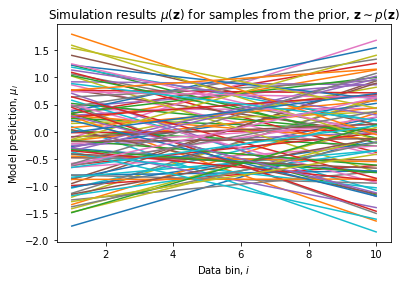

In [179]:
for _ in range(100):
    z = np.random.rand(2)
    plt.plot(range(1, 11), simulator(z));
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Simulation results ${\mu}(\mathbf{z})$ for samples from the prior, $\mathbf{z}\sim p(\mathbf{z})$");

Assuming that measurement errors for each data bin are Gaussian, a typical likelihood-based analysis would now exploit the $\chi^2$ function
$$
\chi^2 = -2\ln p(\mathbf{x}_0|\mathbf{z}) = \sum_{i=1}^{N_\text{bins}} \frac{(\mu_i(\mathbf{z}) - x_{0,i})^2}{\sigma^2}\;,
$$
where $\mathbf{x}_0$ referes to the measured flux, $\boldsymbol{\mu}(\mathbf{z})$ is the result of the line simulator model given model parameters $\textbf{z}$, $\sigma$ refers to the standard deviation of the measurement noise, and $N_\text{bins} = 10$ is the number of bins. This is *not* will do here.

### Our "detector noise"

Instead, a likelihood-free (or simulator based) analysis is based on random draws from the likelihood (aka *forward model*), $\mathbf{x}\sim p(\mathbf{x}|\mathbf{z})$.  Since we are assuming in the current example that measurement noise is Gaussian, we just have to add zero-mean Gaussian noise to the simulator results.  We do this with a separate function.

In [189]:
def noise(mu, z = None, sigma=0.1):
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return x

Now we can generate noisy lines!

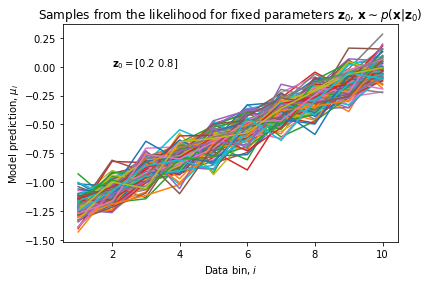

In [190]:
z0 = np.array([0.2, 0.8])  # Some fixed parameters

for _ in range(100):
    plt.plot(range(1, 11), noise(simulator(z0)));
plt.annotate("$\mathbf{z}_0 =$"+str(z0), (2, 0));
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Samples from the likelihood for fixed parameters $\mathbf{z}_0$, $\mathbf{x} \sim p(\mathbf{x}|\mathbf{z}_0)$");

### The generative model

Data scientists sometimes talk about *generative models*.  For us, this refers simply to a sampler that both generates a random draw from the prior, $p(\mathbf{z})$, and subsequently a corresponding random draw from the forward model: $\mathbf{x}, \mathbf{z} \sim p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})$.
Such $(\mathbf{x},\mathbf{z})$ pairs are samples from the generative model.  Drawing from the generative model and throwing away $\mathbf{z}$ is equivalent to sampling from the marginal likelihood (aka Bayesian evidence), $\mathbf{x} \sim p(\mathbf{x})$.

Let us plot random samples from the marginal likelihood!  We also show in red a sample from the forward model for our specific reference parameters ($\mathbf{z}_0$): $\mathbf{x}_0 \sim p(\textbf{x}|\textbf{z}_0)$.

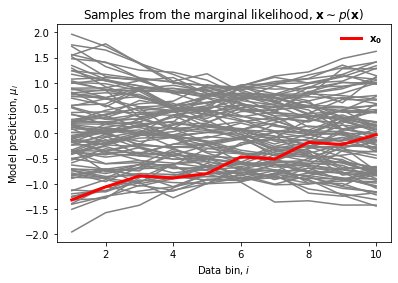

In [191]:
for _ in range(100):
    plt.plot(range(1, 11), noise(simulator(np.random.rand(2))), color='0.5');
plt.xlabel("Data bin, $i$");
plt.ylabel("Model prediction, $\mu_i$");
plt.title("Samples from the marginal likelihood, $\mathbf{x} \sim p(\mathbf{x})$");

# Define mock data
x0 = noise(simulator(z0))
plt.plot(range(1, 11), x0, lw = 3, color='r', label = "$\mathbf{x_0}$")
plt.legend(frameon = False);

Additional information: The noise could be also simulated within the function `simulator`, and the function `noise` could just do nothing. However, often the physics simulation is slow, but adding (Gaussian, Poission, etc) measurement noise is fast.  In these cases the split functions enable to train networks with different noise realizations without rerunning the simulator.  The basic logic is: simulator = slow, noise = fast.

## Parameter estimation with *swyft* (verbose and without nesting)

Now we are ready to solve the inverse problem and derive the posterior $p(\mathbf{z}|\mathbf{x}_0)$, using *swyft*.  Let's do this step-by-step to highlight the important steps.  We will consider nesting as well as a convenience function for doing everything in one go further below.

### Instantiating the iP3 sample cache

First we have to instantiate a simulation cache, which is the place where all simulation results are stored. *swyft* offers the options to store them on disk (for later re-use) for simply in memory.  We chose the memory option here.

In [192]:
cache = swyft.MemoryCache(zdim = 2, xshape = x0.shape)

Creating new cache.


### Filling iP3 sample cache with simulated data

The next step is to fill the iP3 sample cache with simulations over the complete prior range.  We do this by first generating an intensity object that covers the complete prior, then adding the necessary parameters points to the cache, and finally running the simulator for the newly added points.

Note: Run this cell twice and see what happens.

In [194]:
intensity = swyft.get_unit_intensity(expected_n=10000, dim=2)
cache.grow(intensity)
cache.simulate(simulator)

No new simulator runs required.
No simulations required.


### Extract training data from cache

We instantiate a `Points` object that pulls out the training data from the sample cache.  We also add the noise model here, which will be run each time a sample is picked from the point list.

In [206]:
points = swyft.Points(cache, intensity, noise)
print("Number of simulations in `points`:", len(points))

No new simulator runs required.
Number of simulations in `points`: 10106


### Estimate 1-dim marginal posteriors using a ratio estimator

We are now ready to instantiate a ratio estimator object and train it on the simulated points.

In [207]:
re = swyft.RatioEstimator(points, device=DEVICE)
re.train(max_epochs=3, batch_size=32, lr_schedule=[1e-3])

yshape (shape of features between head and legs): 10
Start training
LR iteration 0
Validation loss: 51.13752120733261
Validation loss: 47.28243446350098
Validation loss: 52.43531161546707
Total epochs: 3


### Plot 1-dim marginal posteriors

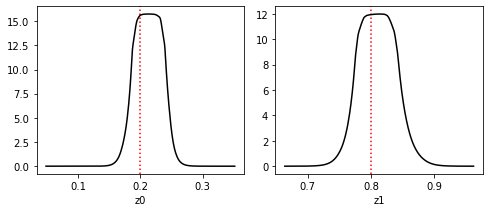

In [188]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (8, 3), ncol = 2, params = [0, 1])

Nice!

### Comparison with expected results

### Run the analysis

Now we can run the analysis. The function `run` takes as input the target observation $\mathbf{x}_0$, the dimensionality of the parameter space $\mathbf{z}$, the simulator function and the (optional) noise function.

The analysis steps involve:
- Creation of simulation cache in memory
- Filling the simulation cache with parameter samples from the prior
- Running simulations for these parameter samples
- Training a neural network to estimate the posterior

In [141]:
points, re = run(x0, simulator, zdim = 2, noise = noise, device = DEVICE)

Simulate:   2%|▏         | 151/9925 [00:00<00:06, 1502.09it/s]

Creating new cache.
Adding 9925 new samples. Run simulator!


Simulate: 100%|██████████| 9925/9925 [00:06<00:00, 1477.30it/s]


yshape (shape of features between head and legs): 10
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 23.08719700574875
Validation loss: 20.589200794696808
Validation loss: 21.214704930782318
Total epochs: 3


Simulate:   2%|▏         | 144/9006 [00:00<00:06, 1433.70it/s]

Constrained posterior area: 0.09061467367766984
Adding 9006 new samples. Run simulator!


Simulate: 100%|██████████| 9006/9006 [00:06<00:00, 1460.01it/s]


yshape (shape of features between head and legs): 10
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 43.02204871177673
Validation loss: 39.696998834609985
Validation loss: 42.61716675758362
Total epochs: 3


Simulate: 100%|██████████| 5/5 [00:00<00:00, 1091.02it/s]

Constrained posterior area: 0.09058192138171196
Adding 5 new samples. Run simulator!
yshape (shape of features between head and legs): 10
Start training


No new simulator runs required.
LR iteration 0
Validation loss: 49.84665608406067
Validation loss: 41.312286138534546
Validation loss: 42.581766843795776
Total epochs: 3


In [142]:
# 2-dim posteriors
re2 = swyft.RatioEstimator(points, combinations = [[0, 1]], device=DEVICE)
re2.train(max_epochs=5, batch_size=64, lr_schedule=[1e-3, 3e-4, 1e-4])

yshape (shape of features between head and legs): 10
Start training
LR iteration 0
Validation loss: 15.264149844646454
Validation loss: 12.3400559425354
Validation loss: 11.422736763954163
Validation loss: 11.301538586616516
Validation loss: 12.620964884757996
Total epochs: 5
LR iteration 1
Validation loss: 11.567525267601013
Validation loss: 11.98474133014679
Total epochs: 2
LR iteration 2
Validation loss: 10.567328333854675
Validation loss: 11.116313099861145
Total epochs: 2


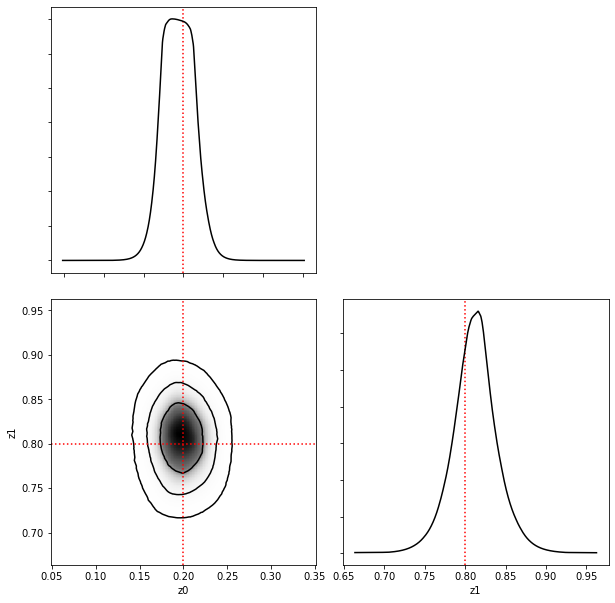

In [143]:
swyft.corner(re, re2, x0 = x0*1.0001, z0 = z0, cmap = 'Greys', dim = 10, max_n_points = 10000)

In [155]:
print("Expected error z_0:", 0.1/np.sqrt(10)/2)

Expected error z_0: 0.015811388300841896


## Parameter estimation with *swyft*

Now we are ready to solve the inverse problem and derive the posterior $p(\mathbf{z}|\mathbf{x}_0)$, using *swyft*.

### Boiler plate implementation of analysis steps (can be skipped on first reading)

The below function implements the required analysis steps in a rather verbose and explicit way.  In later versions of *swyft* we plan to abstract away much of the boiler plate code.

In [144]:
def run(x0, simulator, noise = None, cache = None, n_train = 10000, zdim = None, n_rounds = 3, device = 'cpu', max_epochs = 10, batch_size = 64,  lr_schedule = [1e-3]):
    if cache is None:
        cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)
    intensities = []
    res = []
    intensity = swyft.get_unit_intensity(expected_n=n_train, dim=zdim)
    intensities.append(intensity)
    for i in range(n_rounds):
        if i == 0:
            intensity = swyft.get_unit_intensity(expected_n=n_train, dim=zdim)
        else:
            intensity = swyft.get_constrained_intensity(expected_n=n_train, ratio_estimator=res[-1], x0=x0, threshold=1e-5)
        intensities.append(intensity)   
        cache.grow(intensities[-1])
        cache.simulate(simulator)
        points = swyft.Points(cache, intensities[-1], noise)
        re = swyft.RatioEstimator(points, device=device)
        res.append(re)
        res[-1].train(max_epochs=max_epochs, batch_size=batch_size, lr_schedule=lr_schedule)
    return points, res[-1]

### Run the analysis

Now we can run the analysis. The function `run` takes as input the target observation $\mathbf{x}_0$, the dimensionality of the parameter space $\mathbf{z}$, the simulator function and the (optional) noise function.

The analysis steps involve:
- Creation of simulation cache in memory
- Filling the simulation cache with parameter samples from the prior
- Running simulations for these parameter samples
- Training a neural network to estimate the posterior

In [141]:
points, re = run(x0, simulator, zdim = 2, noise = noise, device = DEVICE)

Simulate:   2%|▏         | 151/9925 [00:00<00:06, 1502.09it/s]

Creating new cache.
Adding 9925 new samples. Run simulator!


Simulate: 100%|██████████| 9925/9925 [00:06<00:00, 1477.30it/s]


yshape (shape of features between head and legs): 10
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 23.08719700574875
Validation loss: 20.589200794696808
Validation loss: 21.214704930782318
Total epochs: 3


Simulate:   2%|▏         | 144/9006 [00:00<00:06, 1433.70it/s]

Constrained posterior area: 0.09061467367766984
Adding 9006 new samples. Run simulator!


Simulate: 100%|██████████| 9006/9006 [00:06<00:00, 1460.01it/s]


yshape (shape of features between head and legs): 10
Start training
No new simulator runs required.
LR iteration 0
Validation loss: 43.02204871177673
Validation loss: 39.696998834609985
Validation loss: 42.61716675758362
Total epochs: 3


Simulate: 100%|██████████| 5/5 [00:00<00:00, 1091.02it/s]

Constrained posterior area: 0.09058192138171196
Adding 5 new samples. Run simulator!
yshape (shape of features between head and legs): 10
Start training


No new simulator runs required.
LR iteration 0
Validation loss: 49.84665608406067
Validation loss: 41.312286138534546
Validation loss: 42.581766843795776
Total epochs: 3


In [142]:
# 2-dim posteriors
re2 = swyft.RatioEstimator(points, combinations = [[0, 1]], device=DEVICE)
re2.train(max_epochs=5, batch_size=64, lr_schedule=[1e-3, 3e-4, 1e-4])

yshape (shape of features between head and legs): 10
Start training
LR iteration 0
Validation loss: 15.264149844646454
Validation loss: 12.3400559425354
Validation loss: 11.422736763954163
Validation loss: 11.301538586616516
Validation loss: 12.620964884757996
Total epochs: 5
LR iteration 1
Validation loss: 11.567525267601013
Validation loss: 11.98474133014679
Total epochs: 2
LR iteration 2
Validation loss: 10.567328333854675
Validation loss: 11.116313099861145
Total epochs: 2


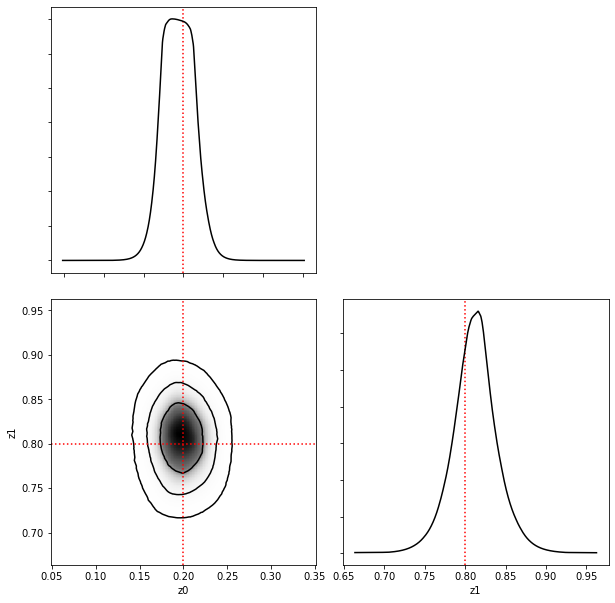

In [143]:
swyft.corner(re, re2, x0 = x0*1.0001, z0 = z0, cmap = 'Greys', dim = 10, max_n_points = 10000)

In [155]:
print("Expected error z_0:", 0.1/np.sqrt(10)/2)

Expected error z_0: 0.015811388300841896
